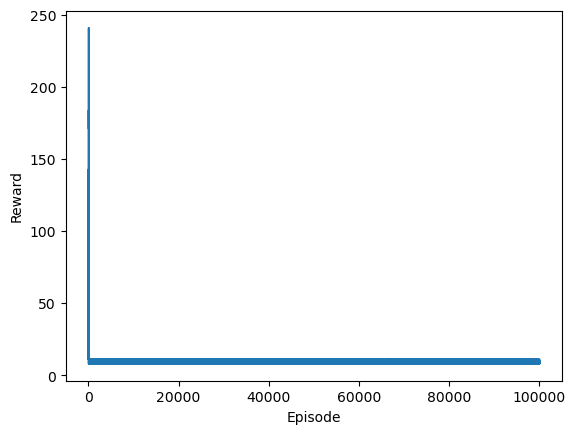

In [3]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import gymnasium as gym
import numpy as np
import optax
import matplotlib.pyplot as plt

def create_network(rng, layer_sizes):
    keys = random.split(rng, len(layer_sizes) - 1)
    params = [(random.normal(rng, (in_dim, out_dim)) / np.sqrt(in_dim), np.zeros(out_dim))
                for rng, in_dim, out_dim in zip(keys, layer_sizes[:-1], layer_sizes[1:])]
    return params

def forward(params, state):
    activations = state
    for W, b in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, W) + b)
    logits = jnp.dot(activations, params[-1][0]) + params[-1][1]
    return logits

def rewards_to_go(policy_params, model_params, state, action_dim, state_dim, discount_factor=0.99, n_steps=10):
    rtg = 0
    current_state = state
    current_discount = 1.0
    for _ in range(n_steps):
        action_logits = forward(policy_params, current_state)
        action_probs = jax.nn.softmax(action_logits)
        action_probs = np.asarray(action_probs).astype("float64")
        action_probs_norm = action_probs/action_probs.sum()
        # we might need implement a eps-greedy strategy
        # currently use a stochastic strategy
        action = np.random.choice(action_dim, p=action_probs_norm)
        state_action = jnp.hstack([current_state, jnp.array([action])])
        next_state_pred, reward_pred = jnp.split(forward(model_params, state_action), [state_dim])
        rtg += current_discount * reward_pred
        current_discount *= discount_factor
        current_state = next_state_pred
    return rtg

@jit
def loss(params, state, action, advantage):
    logits = forward(params, state)
    log_probs = logits - jax.scipy.special.logsumexp(logits)
    log_prob = log_probs[action]
    return jnp.sum(-log_prob * advantage)

@jit
def model_loss(params, state, action, target):
    state_action = jnp.hstack([state, action])
    prediction = forward(params, state_action)
    return jnp.mean(jnp.square(target - prediction))

policy_grad_loss = jit(grad(loss, argnums=0))
model_grad_loss = jit(grad(model_loss, argnums=0))

def train(rng, env, num_episodes=100000):
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_hidden_dim = 256
    policy_params = create_network(rng, [state_dim, policy_hidden_dim, policy_hidden_dim, policy_hidden_dim, action_dim])
 
    model_input_dim = state_dim + 1
    model_hidden_dim = 256
    model_output_dim = state_dim + 1
    model_params = create_network(rng, [model_input_dim, model_hidden_dim, model_hidden_dim, model_hidden_dim, model_output_dim])

    discount_factor = 0.99
    lr = 1e-4
    optimizer = optax.adam(lr)

    opt_state_policy = optimizer.init(policy_params)
    opt_state_model = optimizer.init(model_params)

    rewards_history = []
    """ This block cannot be jitted due to conditional argument update_model
    @jit
    def train_step(step, opt_state, params, state, action, target, update_model=True):
        if update_model:
            g = model_grad_loss(params, state, action, target)
        else:
            g = policy_grad_loss(params, state, action, target)
        updates, new_opt_state = optimizer.update(g, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_opt_state, new_params
    """
    @jit
    def train_policy_step(step, opt_state, params, state, action, advantage):
        g = policy_grad_loss(params, state, action, advantage)
        updates, new_opt_state = optimizer.update(g, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_opt_state, new_params

    @jit
    def train_model_step(step, opt_state, params, state, action, target):
        g = model_grad_loss(params, state, action, target)
        updates, new_opt_state = optimizer.update(g, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_opt_state, new_params


    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action_logits = forward(policy_params, state)
            action_probs = jax.nn.softmax(action_logits)
            action_probs = np.asarray(action_probs).astype("float64")
            action_probs_norm = action_probs/action_probs.sum()
            action = np.random.choice(action_dim, p=action_probs_norm)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            rtg = rewards_to_go(policy_params, model_params, state, action_dim, state_dim, discount_factor)
            advantage = jnp.array(reward + discount_factor * rtg - rewards_to_go(policy_params, model_params, state, action_dim, state_dim))

            opt_state_model, model_params = train_model_step(0, opt_state_model, model_params, state, jnp.array([action]), jnp.hstack([next_state, jnp.array([reward])]))
            opt_state_policy, policy_params = train_policy_step(0, opt_state_policy, policy_params, state, jnp.array([action]), advantage)

            state = next_state

        rewards_history.append(total_reward)

    return policy_params, rewards_history

# Training and plotting the results
env = gym.make("CartPole-v1")
rng = random.PRNGKey(0)
policy_params, rewards_history = train(rng, env)

plt.plot(rewards_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()
